In [1]:
from contextlib import suppress
import matplotlib
import matplotlib.pyplot as plt

import math
import numpy as np
import os
import warnings
from zipfile import ZipFile

from skimage.io import imread, imsave

from keras.preprocessing.image import ImageDataGenerator
from keras import applications
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.utils import to_categorical

from sklearn.metrics import accuracy_score, classification_report

%matplotlib inline

Using TensorFlow backend.


# Data Preparation

### Download the [UC Merced Land Use dataset](http://vision.ucmerced.edu/datasets/landuse.html)

### Extract image files from the zipped archive, if necessary

In [2]:
with suppress(FileExistsError):
    os.mkdir('data')

source_dir = os.path.join('data', 'UCMerced_LandUse', 'Images')

# Download the zipped dataset from http://vision.ucmerced.edu/datasets/landuse.html 
if not os.path.isdir(source_dir):
    with ZipFile('UCMerced_LandUse.zip') as z:
        z.extractall(path='data')

In [3]:
# Set random seed for reproducibility
np.random.seed(8)

### Randomly assign each image to train, validate, or test folder, segregated by class name

In [4]:
"""
Create image directory hierarchy that looks like this:
./data/flow/
            train/
                  agriculture/
                  airplane/
                  ...
            validate/
                     agriculture/
                     airplane/
                     ...
            test/
                 agriculture/
                 airplane/
                 ...
"""

# Collect class names from directory names in './data/UCMerced_LandUse/Images/'
class_names = os.listdir(source_dir)    

# Create path to image "flow" base directory
flow_base = os.path.join('data', 'flow')

# Create pathnames to train/validate/test subdirectories
target_dirs = {target: os.path.join(flow_base, target) for target in ['train', 'validate', 'test']}

if not os.path.isdir(flow_base):

    # Make new directories
    os.mkdir(flow_base)
    
    for target in ['train', 'validate', 'test']:
        target_dir = os.path.join(flow_base, target)
        os.mkdir(target_dir)
        for class_name in class_names:
            class_subdir = os.path.join(target_dir, class_name)
            os.mkdir(class_subdir)

    # suppress low-contrast warning from skimage.io.imsave
    warnings.simplefilter('ignore', UserWarning)
    
    # Copy images from ./data/UCMerced_LandUse/Images to ./data/flow/<train, validate, test>    
    for root, _, filenames in os.walk(source_dir):
        if filenames:
            class_name = os.path.basename(root)

            # Randomly shuffle filenames
            filenames = np.random.permutation(filenames)
            for target, count in [('train', 80), ('validate', 10), ('test', 10)]:
                target_dir = os.path.join(flow_base, target, class_name)
                for filename in filenames[:count]:
                    filepath = os.path.join(root, filename)
                    image = imread(filepath)
                    basename, _ = os.path.splitext(filename)
                    # Convert TIF to PNG to work with Keras ImageDataGenerator.flow_from_directory
                    target_filename = os.path.join(target_dir, basename + '.png')
                    imsave(target_filename, image)
            
                filenames = filenames[count:]
    
    # Show future warnings during development
    warnings.resetwarnings()

# Get training set bottleneck features from pretrained CNN

In [5]:
def extract_bottleneck_features(model, dataset, batch_size=64):
    """
    Extract botteleneck features for the input dataset (train/validate/test)
    by predicting on the convolutional portion only of a pretrained model.
        
    Inputs:
        model: Pre-trained deep learning model, excluding fully-connected top model
               e.g. applications.VGG16(include_top=False, weights='imagenet')
        dataset = string label for dataset image directory ['train', 'validate', 'test']
    
    Return:
        Return bottleneck features as numpy.array
    """

    image_data_gen = ImageDataGenerator(rescale=1.0/255)
    image_generator = image_data_gen.flow_from_directory(target_dirs[dataset],
                                                         batch_size=batch_size,
                                                         shuffle=False
                                                         )
    
    print(f'Generating "{dataset}" bottleneck predictions')
    
    image_count = 0
    X_batches, Y_batches = [], []
    for X, Y in image_generator:
        X_batches.append(model.predict_on_batch(X))
        Y_batches.append(Y)
        image_count += X.shape[0]
        # Must interrupt image_generator
        if image_count >= image_generator.n:
            break
    
    X = np.concatenate(X_batches)
    Y = np.concatenate(Y_batches)
    
    print(f'   Features of shape {X.shape} extracted for model "{model.name}"')
    return X, Y

### Select a pre-trained model from the Keras.applications module; e.g. Xception, VGG16 ...

In [6]:
# Let's try the VGG16 model
pretrained_model = applications.VGG16(include_top=False, weights='imagenet')

### Extract bottleneck features for each dataset: train, validate, and test

In [7]:
num_classes = len(class_names)
X, Y = dict(), dict()
for dataset in ['train', 'validate', 'test']:
    # Extract bottleneck features from pretrained model, predicting on images from "dataset" directory
    X[dataset], Y[dataset] = extract_bottleneck_features(pretrained_model, dataset)

Found 1680 images belonging to 21 classes.
Generating "train" bottleneck predictions
   Features of shape (1680, 8, 8, 512) extracted for model "vgg16"
Found 210 images belonging to 21 classes.
Generating "validate" bottleneck predictions
   Features of shape (210, 8, 8, 512) extracted for model "vgg16"
Found 210 images belonging to 21 classes.
Generating "test" bottleneck predictions
   Features of shape (210, 8, 8, 512) extracted for model "vgg16"


# Train a fully-connected model using bottleneck features

In [8]:
def build_fully_connected(input_shape, num_classes):
    """
    Create a fully-connected model to train or test on UC Merced dataset.
    """
    model = Sequential()
    model.add(Flatten(input_shape=input_shape))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    return model

In [9]:
# Build, compile, and fit the model

model = build_fully_connected(input_shape=X['train'].shape[1:], num_classes=num_classes)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model_fit_history = model.fit(X['train'], Y['train'], batch_size=64, epochs=20,
                              verbose=2, validation_data=(X['validate'], Y['validate'])
                             )

Train on 1680 samples, validate on 210 samples
Epoch 1/20
4s - loss: 2.5216 - acc: 0.3440 - val_loss: 0.9380 - val_acc: 0.7571
Epoch 2/20
4s - loss: 1.0636 - acc: 0.6560 - val_loss: 0.5892 - val_acc: 0.8524
Epoch 3/20
4s - loss: 0.7982 - acc: 0.7458 - val_loss: 0.4973 - val_acc: 0.8619
Epoch 4/20
4s - loss: 0.5820 - acc: 0.8071 - val_loss: 0.4887 - val_acc: 0.8524
Epoch 5/20
4s - loss: 0.5019 - acc: 0.8369 - val_loss: 0.4702 - val_acc: 0.8476
Epoch 6/20
4s - loss: 0.3979 - acc: 0.8661 - val_loss: 0.3716 - val_acc: 0.8905
Epoch 7/20
4s - loss: 0.3151 - acc: 0.9060 - val_loss: 0.3699 - val_acc: 0.8810
Epoch 8/20
4s - loss: 0.2895 - acc: 0.9054 - val_loss: 0.3452 - val_acc: 0.9095
Epoch 9/20
4s - loss: 0.2209 - acc: 0.9333 - val_loss: 0.3210 - val_acc: 0.9095
Epoch 10/20
4s - loss: 0.1923 - acc: 0.9405 - val_loss: 0.3125 - val_acc: 0.9000
Epoch 11/20
4s - loss: 0.1586 - acc: 0.9577 - val_loss: 0.2932 - val_acc: 0.9286
Epoch 12/20
4s - loss: 0.1490 - acc: 0.9554 - val_loss: 0.3190 - val_ac

### Let's see a plot of training loss vs. validation loss

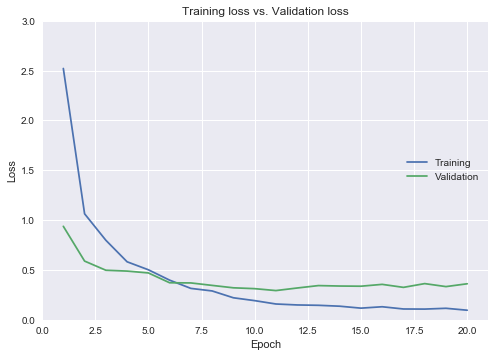

In [10]:
matplotlib.style.use('seaborn')
epochs = len(model_fit_history.history['loss'])
max_loss = max(max(model_fit_history.history['loss']), max(model_fit_history.history['val_loss']))
plt.axis([0, epochs+1, 0, math.ceil(max_loss)])
x = np.arange(1, epochs+1)
plt.plot(x, model_fit_history.history['loss'])
plt.plot(x, model_fit_history.history['val_loss'])
plt.title('Training loss vs. Validation loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='right')
plt.show()

<hr>

### To avoid overfitting, let's retrain the model, stopping at the epoch with smallest validation loss.

In [11]:
epochs = np.argmin(model_fit_history.history['val_loss']) + 1
print(f'Stop training at {epochs} epochs')

model = build_fully_connected(input_shape=X['train'].shape[1:], num_classes=num_classes)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(X['train'], Y['train'], batch_size=64, epochs=epochs, verbose=0)

# Save model weights for test dataset predictions
fit_model_weights = model.get_weights()

Stop training at 11 epochs


### Evaluate the model on the test images

In [12]:
# Start by building the same fully-connected model
model = build_fully_connected(input_shape=X['test'].shape[1:], num_classes=num_classes)

# Load weights from the model fit on the training data
model.set_weights(fit_model_weights)

# Predict on the test images
y_pred = model.predict_classes(X['test'], verbose=0)

### Print classification results

In [13]:
# Flatten Y into a vector
y_test = np.nonzero(Y['test'])[1]
accuracy = accuracy_score(y_test, y_pred)
print(f'Model predication accuracy: {accuracy:.3f}')
print(f'\nClassification report:\n {classification_report(y_test, y_pred)}')

Model predication accuracy: 0.895

Classification report:
              precision    recall  f1-score   support

          0       1.00      1.00      1.00        10
          1       1.00      1.00      1.00        10
          2       0.91      1.00      0.95        10
          3       0.90      0.90      0.90        10
          4       0.89      0.80      0.84        10
          5       1.00      1.00      1.00        10
          6       0.88      0.70      0.78        10
          7       0.91      1.00      0.95        10
          8       0.83      1.00      0.91        10
          9       0.80      0.80      0.80        10
         10       1.00      1.00      1.00        10
         11       0.83      1.00      0.91        10
         12       0.64      0.70      0.67        10
         13       0.77      1.00      0.87        10
         14       0.80      0.80      0.80        10
         15       1.00      1.00      1.00        10
         16       0.90      0.90      0

###  Test accuracy: 89.5%. Impressive for such a small image dataset.